# Homework # 1: Audio Classification

In this work you will master all the basic skills with audio applied to the problem of classification.

You will:
* 🔥 master `torchaudio` as a library for working with audio in conjunction with `torch`
* 🔊 try out the different feature representations of the audio signal in practice
* 👨‍🔬 develop an audio classification model based on recurrent networks
* 🗣 test the trained model on real data (on your own voice)

We will work with the **AudioMNIST** dataset (similar to the MNIST dataset, but from the audio world). It was presented in [paper](https://arxiv.org/pdf/1807.03418.pdf) 📑 , dedicated to the study of audio representations. But this article is indirectly related to our homework.

![](https://miro.medium.com/max/1400/0*vkUOacXAsNIQCpDu.png)

### Installing libraries

We will work with `torch` version `1.7.1` (with the corresponding version of `touchaudio`).

While the installation is in progress, you can run your eyes through the [documentation](https://pytorch.org/audio/stable/transforms.html) to `torchaudio` – from this library, we will only need a few transforms, as well as audio loading functions.

In [1]:
#!L
! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2  -f https://download.pytorch.org/whl/torch_stable.html

! pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 17kB/s 
     |████████████████████████████████| 12.8MB 261kB/s 
     |████████████████████████████████| 7.6MB 7.4MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1+cu101 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
     |████████████████████████████████| 20.0MB 55.0MB/s 
     |████████████████████████████████| 11.6MB 9.0MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1+cu101 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.17.5 wh

In [2]:
! apt-get install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrwb0 amd64 0.1.3-2.1 [45.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main a

### Obtaining AudioMNIST dataset 0️⃣1️⃣2️⃣3️⃣4️⃣5️⃣6️⃣7️⃣8️⃣9️⃣

To get the dataset, clone the repository (`~1Gb`) running the code below:

In [1]:
!git clone https://github.com/yandexdataschool/speech_course.git

fatal: destination path 'speech_course' already exists and is not an empty directory.


In [2]:
import os
os.chdir("speech_course/week_02")

In [3]:
#!L:bash
# If in Yandex Datasphere run as below:
!git clone https://github.com/soerenab/AudioMNIST
# If run locally:
# ! git clone https://github.com/soerenab/AudioMNIST

fatal: destination path 'AudioMNIST' already exists and is not an empty directory.


In [13]:
#!L
import torch
import torchaudio
from torchaudio.transforms import Resample, MelSpectrogram
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import shutil

from typing import List, Tuple
from glob import glob

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, Audio
%matplotlib inline

If you run this Jupyter Notebook on a computer with a video card (**GPU**), you need to specify which card you want to work with, and you also need to make sure that `torch` sees it. 

If you *really* want, you can do your homework without using a video card, but then the training will take a very long time.

**Tip**: if the video card is an exhausted resource (i.e. you have a usage quota, or you pay for usage), then it is better to **debug** training without the GPU: to make sure that the model does not crash with an error, and the loss decreases in the first iterations.

In [5]:
#!L
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

Only CPU found! 💻


### Prepare the set for testing 🎛

The set for validation will be taken from the `AudioMNIST` dataset. But as you know, there is a risk of overfitting not only on training set, but also on validation set. Therefore, for the purity of the experiment, we will evaluate the work of our algorithm on real data, namely, our voice!

You can record your own (or someone else's) voice speaking out the numbers, so you will have a real mini-dataset for testing. You will need it exclusively. We will test your model on our **own** testing set. 👀

To record a voice, you can use web-sites like [this](https://voice-recorder-online.com), and also you can do this via the command line (you need the `sox` utility):

```
rec recording.wav trim 0 10   # record a 10-second audio fragment
of play recording.wav         # listen to it
```

The recording may differ not only in format (be `mp3`, `ogg`), but in sampling rate (`22050Hz`, `44100Hz`), being a stereo recording, and so on. 

To bring the record to the unified format we need:

In [6]:
#!S
# -> 16kHz, 16bit, mono
! sox recording.wav -r 16000 -b 16 -c 1 recording_16kHz.wav

In [7]:
#!L
x, sr = torchaudio.load('recording_16kHz.wav')
x = x[0].numpy()

DIGIT_NAMES = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
print(", ".join(DIGIT_NAMES))
display(Audio(x, rate=sr))

zero, one, two, three, four, five, six, seven, eight, nine


You need to break this record into fragments, each of which would contain audio with the pronunciation of **only one** digit.

Let's use the energy ⚡️ VAD!

**Calculate** the energy of the signal in a windowed way (choose the window size however you like) and look at its plot.

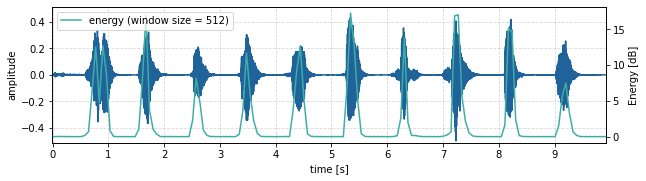

In [8]:
#!L
# empirically, you can choose the optimal window size
win_size = 1024

energies_db = []
for i in range(len(x) // win_size + 1):
    x_win = x[i * win_size: (i + 1) * win_size]
    # calculate energy of signal fragment
    energy = np.sum(x_win ** 2)
    energies_db.append(energy)
energies_db = np.array(energies_db)

def plot_signal_energies(x, sr, energies_db, intervals=None):
    fig = plt.figure(figsize=(len(x) / sr, 2.5))
    plt.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')
    plt.ylim([-0.51, 0.51])
    plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:            
            plt.gca().add_patch(patches.Rectangle(
                (a, -0.51), (b - a), 1.2, 
                linewidth=1, edgecolor='none', 
                facecolor='#3caea3', alpha=0.3))

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)), energies_db, 
        color='#3caea3', label='energy (window size = 512)')
    plt.ylabel('Energy [dB]')
    plt.legend(loc='best')
    plt.show()

plot_signal_energies(x, sr, energies_db)

I hope you will have no trouble coming up with **a heuristic** for finding the boundaries of spoken words.

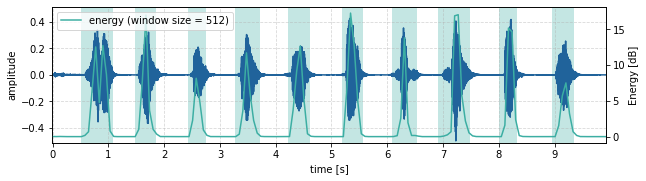

In [9]:
#!L
# list of digit intervals [(a_0, b_0), ...]
# where a_i -- first audio sample of spoken word, b_i -- last sample
intervals = []

threshold = 0.023
accepted_signal_mask = energies_db > threshold
signal_jump_mask = accepted_signal_mask[:-1] != accepted_signal_mask[1:]
signal_jump_idxs = np.arange(len(signal_jump_mask))[signal_jump_mask]
pairs = signal_jump_idxs.reshape((-1, 2))
intervals = list(pairs * win_size)

plot_signal_energies(x, sr, energies_db, intervals)

We will split the original record into fragments and save them to the directory with the dataset.

In [10]:
#!L
test_directory = 'AudioMNIST/data/test'
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

n = 0
for a, b in intervals:
    x_digit = x[a: b]
    path = f'{test_directory}/{n % 10}_test_{n // 10}.wav'
    print(f'"{DIGIT_NAMES[n % 10]}" -> {path}')
    n += 1
    
    torchaudio.save(path, torch.FloatTensor(x_digit), sr)
    display(Audio(path))

"zero" -> AudioMNIST/data/test/0_test_0.wav


"one" -> AudioMNIST/data/test/1_test_0.wav


"two" -> AudioMNIST/data/test/2_test_0.wav


"three" -> AudioMNIST/data/test/3_test_0.wav


"four" -> AudioMNIST/data/test/4_test_0.wav


"five" -> AudioMNIST/data/test/5_test_0.wav


"six" -> AudioMNIST/data/test/6_test_0.wav


"seven" -> AudioMNIST/data/test/7_test_0.wav


"eight" -> AudioMNIST/data/test/8_test_0.wav


"nine" -> AudioMNIST/data/test/9_test_0.wav


### Class for the dataset 🗄

The class below (the a subclass of `torch.utils.data.Dataset`) holds the logic of loading `AudioMNIST` dataset. All the file handling routins are already written, so you are required to do the following:

* 👩‍💻 completed the code (at least, in the `__getitem__` method) for obtaining the audio features (representations) you need from the signal
* 🤔 explain your choice with a comment in `__getitem__`

You could use the waveform itself as an audio representation (features), **but** as you know from the lecture (*DSP Basics*), this is not the best representation for many tasks.

You are able to return to this stage many times while doing you homework, so iterate from simple representations to sophisticated ones.

In [47]:
class NormalizeTransform(nn.Module):
    def __init__(self):
        super(NormalizeTransform, self).__init__()

    def forward(self, x):
        return (x - x.mean()) / (x.std() + + 1e-7)

class TakeLog10Transform(nn.Module):
    def __init__(self):
        super(TakeLog10Transform, self).__init__()
    
    def forward(self, x):
        return torch.log10(x)


#!L
class AudioMNISTDataset(data.Dataset):
    def __init__(
        self,
        directory: str,
        mode='train',
        new_freq=16000,
        n_fft=800,
        n_mels=70,
        f_min=1,
        f_max=8000
    ):
        self.mode = mode
        self.filepaths = []
        self.labels = []
        for filepath in sorted(glob(os.path.join(directory, '*', '?_*_*.wav'))):
            digit, speaker, example_id = os.path.basename(filepath).replace('.wav', '').split('_')
            add = False
            if speaker == 'test' and mode == 'test':
                add = True
            if speaker != 'test' and int(speaker) % 6 == 0 and mode == 'valid':
                add = True
            if speaker != 'test' and int(speaker) % 6 != 0 and mode == 'train':
                add = True
            if add:
                self.filepaths.append(filepath)
                self.labels.append(int(digit))
                
        print(f"Dataset [{mode}]: {len(self.filepaths)} audios")
        
        _, sample_rate = torchaudio.load(self.filepaths[0])
        
        transforms = []
        transforms.append(Resample(orig_freq=sample_rate, new_freq=new_freq))
        transforms.append(
            MelSpectrogram(
                sample_rate=new_freq,
                n_fft=n_fft,
                n_mels=n_mels,
                f_min=f_min,
                f_max=f_max
            )
        )

        transforms.append(TakeLog10Transform())
        transforms.append(NormalizeTransform())
        self.transform = nn.Sequential(*transforms)

    def __getitem__(self, idx) -> Tuple[torch.FloatTensor, torch.LongTensor]:
        x, sr = torchaudio.load(self.filepaths[idx])
        y = torch.LongTensor([self.labels[idx]])[0]

        x = self.transform(x[0])
        # ARGUMENTATION:
        # I've chosen this representation, because we have used mel on the seminar, so I
        # tried to use ready solution from torch, and added normalization at the end
        
        # x: audio features
        # y: target digit class
        return x, y
    
    def __len__(self):
        return len(self.filepaths)

In [48]:
#!L
train_dataset = AudioMNISTDataset('AudioMNIST/data', mode='train')
valid_dataset = AudioMNISTDataset('AudioMNIST/data', mode='valid')
test_dataset = AudioMNISTDataset('AudioMNIST/data', mode='test')

Dataset [train]: 25000 audios
Dataset [valid]: 5000 audios
Dataset [test]: 10 audios


It's interesting to see what we got...

You may see some interesting points in your audio representation, and **may want to try a different representation**. 🕵️‍ Or return to this later.

visualize dataset for training


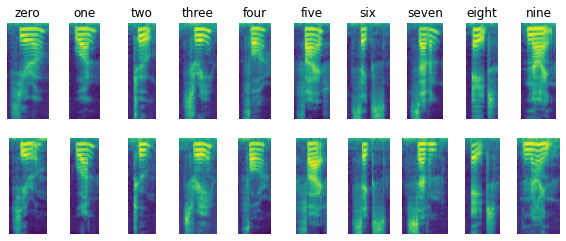

visualize dataset for testing


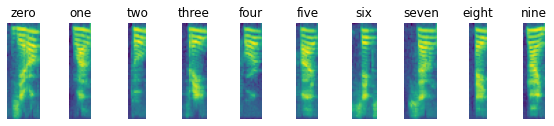

In [49]:
#!L
def show_some_examples(dataset, K, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    for digit in range(10):
        indices = np.where(np.array(dataset.labels) == digit)[0]
        for i in range(K):
            x, y = dataset[indices[i]]
            ax = fig.add_subplot(3, 10, digit + i * 10 + 1)
            # roate
            if i == 0:
                ax.set_title(DIGIT_NAMES[digit])
            ax.imshow(x)
            ax.axis('off')
    plt.show()

print("visualize dataset for training")
show_some_examples(train_dataset, 2)

print("visualize dataset for testing")
show_some_examples(test_dataset, 1)

Can determine **which number is pronounced** looking at it? If so, then the computer can!

Note that the audios have different durations, at least because the words have different numbers of phonemes. Thus, our feature tensors do not have a fixed size either.

```
- Can we bring them to the same size?
- Yes, we can. And it will even work (see the dataset article).
- So why don't we do that?
- This approach has a limited scope. And here's why:
```

* First, in real ASR systems, we do not classify words, but *sounds* (graphemes, phonemes) – they are more difficult to localize and difficult to classify independently. Although, for example, for the task of classifying the sounds of birdsong, this approach would be normal.
* Secondly, convolutional neural networks (actually for which we would like images of the same size) poorly orient in space, since they react to patterns, and may not pay attention to their spatial location. In our problem, the words are quite unique, so they are uniquely identified by a set of sounds (phonemes), so this approach would work. But we're taking a course in **speech recognition and synthesis, not sound classification**. 🙂

### Batch generation class 📦

All DL frameworks work with tensors (not lists of tensors). You need to somehow concatenate audio into a batch, but initially they are of different lengths. You can try zero padding (don't forget to store original length).

In [1]:
#!L
class Collate:
    def __call__(self, batch: List[Tuple[torch.Tensor, torch.Tensor]]):
        X_batch, y_batch = zip(*batch)

        ls = torch.Tensor([x.shape[0] for x in X_batch])
        max_length = int(torch.max(ls))
        xs = torch.cat([F.pad(x.T, [0, max_length - x.shape[0]]) for x in X_batch])
        ys = torch.Tensor(y_batch)
        
        # xs: batch of features
        # ls: batch of lengths
        # ys: batch of targets
        return xs, ls, ys

NameError: ignored

In [ ]:
#!L
collate_fn = Collate()
train_loader = data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, 
    num_workers=4, drop_last=True, collate_fn=collate_fn)
valid_loader = data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False, 
    num_workers=4, collate_fn=collate_fn)
test_loader = data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False, 
    num_workers=1, collate_fn=collate_fn)

xs, ls, ys = next(iter(train_loader))
print(xs.size(), ls.size(), ys.size())

### The neural network classifier 🤖

Write a model for classifying audios. It is desirable to use some recurrent layer in the model. Start with a simple one, and make it more complicated if necessary.

In [ ]:
#!L
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ################################################################################
        # ...
        ################################################################################

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        ################################################################################
        # ...
        ################################################################################
        return x
    
def create_model_and_optimizer(device):
    ################################################################################
    # ...
    ################################################################################
    return model, optimizer

### Training, validation, testing 🏋 ️

The minimally sufficient code for training and testing is already written. But feel free to modify the code (but try not to break the compatibility).

**Tips**:
* before you start long-term training, see how your model behaves on the first iterations/epochs
* it is desirable that the training epoch takes less one minute; if longer, maybe your model is too complex
* models converge quickly, so it hardly makes sense to do training more than 100 epochs

In [ ]:
#!L
def train(model, optimizer, loader, metrics):
    model.train()
    
    losses = []
    for x, lengths, y in loader:
        x, y = x.to(device), y.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x, lengths)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    metrics['train_loss'].append(np.mean(losses) )


def evaluate(model, loader, metrics, mode):
    model.eval()
    
    losses = []
    cm = np.zeros((10, 10), dtype=np.int32)
    with torch.no_grad():
        valid_losses = []
        for x, lengths, y in loader:
            x, y = x.to(device), y.to(device)
            lengths = lengths.to(device)
    
            y_pred = model(x, lengths)
            loss = F.cross_entropy(y_pred, y)
            losses.append(loss.item())

            y_pred = y_pred.argmax(axis=-1)
            for i in range(len(x)):
                cm[y[i].item(), y_pred[i].item()] += 1
    
    metrics[f'{mode}_loss'].append(np.mean(losses))
    metrics[f'{mode}_accuracy'].append(np.trace(cm) / np.sum(cm))
    metrics[f'{mode}_confusion'].append(cm)


def train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader):
    metrics = {
        'train_loss': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_confusion': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_confusion': []
    }

    best_valid_accuracy = 0.0
    for epoch in tqdm(range(20)):
        train(model, optimizer, train_loader, metrics)
                
        evaluate(model, valid_loader, metrics, 'valid')
        evaluate(model, test_loader, metrics, 'test')
        
        if metrics['valid_accuracy'][-1] > best_valid_accuracy:
            best_valid_accuracy = metrics['valid_accuracy'][-1]
            torch.save({
                'state_dict': model.state_dict(), 
                'metrics': metrics
            }, checkpoint_path)
    
    return metrics


checkpoint_path = 'model.pth'
model, optimizer = create_model_and_optimizer(device)

if os.path.exists(checkpoint_path):
    print(f'Loading model weights from {checkpoint_path}')
    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['state_dict'])
    metrics = ckpt['metrics']
    evaluate(model, valid_loader, metrics, 'valid')
    evaluate(model, test_loader, metrics, 'test')
else:
    print('Training model from scratch..')
    metrics = train_from_scratch(model, optimizer, train_loader, valid_loader, test_loader)

### Visualization of the results 📉 📈

We will select the model based on the best accuracy value during validation. Let's evaluate the accuracy of the model on the test set.

In [ ]:
#!L
def plot_accuracies(valid_accuracy, test_accuracy, best_epoch):
    best_valid = valid_accuracy[best_epoch]
    best_test = test_accuracy[best_epoch]
    
    plt.figure(figsize=(7, 3))
    plt.title('Accuracy')
    plt.plot(valid_accuracy, label='valid', color='#20639b')
    plt.plot(test_accuracy, label='test', color='#3caea3')
    plt.grid(linestyle='--', alpha=0.5)
    plt.vlines(best_epoch, 0.6, 1, color='#ed553b', linestyle='--', label='best')
    plt.hlines(best_valid, 0, best_epoch, linestyle='--', color='#555555')
    plt.hlines(best_test, 0, best_epoch, linestyle='--', color='#555555')
    plt.plot(best_epoch, best_valid, marker='o', color='#20639b')
    plt.plot(best_epoch, best_test, marker='o', color='#3caea3')
    plt.text(0, best_valid - 0.02, f"{best_valid:.4f}")
    plt.text(0, best_test - 0.02, f"{best_test:.4f}")
    plt.ylim(0.8, 1.01)
    plt.xlim(0, len(valid_accuracy) - 1)
    plt.xticks(range(len(valid_accuracy)))
    plt.yticks(np.linspace(0.8, 1.0, 11))
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, names, title='Confusion matrix', normalize=False):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)

    if names is not None:
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            kwargs = {
                'color': "white" if cm[i, j] > thresh else "black",
                'horizontalalignment': 'center'
            }
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]), **kwargs)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), **kwargs)

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}')
    plt.show()

    
# choosing model by best accuracy on validation set
best = np.argmax(metrics['valid_accuracy'])
best_cm = metrics['test_confusion'][best]

plot_accuracies(metrics['valid_accuracy'], metrics['test_accuracy'], best)
plot_confusion_matrix(best_cm, range(10))

### Augmentation

Augmentations are applied to training data to improve the generalization ability of the deep neural model. Think about what augmentations you can apply to the audio, and then check how they work by experiment.

In [ ]:
#!S
# run experiments here, reuse previously defined functions

### Conclusions 🧑‍🎓

* What challenges did you encounter while completing this task?
* What skills have you acquired while doing this task?
* How difficult did you find this task (on a scale from 0 to 10), and why?
* What did you like in this homework, and what didn't?

### Grades criteria

```
[ ] (1 point)  implement energy VAD for audio splitting
[ ] (1 point)  explain the reason for choosing the audio representation features
[ ] (3 points) train classification model (> 95% accuracy on validation)
[ ] (2 points) achieve good test-score on our side (> 85% accuracy on hidden sample)
[ ] (2 points) provide augmentation experiments
[ ] (1 point)  write conclusions
```

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells
2. checkpoint of the `model.path` model on the "best" iteration

Save the artifacts to a directory named `{your last name}_{your first name}_hw1` and pack them in `.zip` archive.